Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to use FLAML library.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];

## 2. Classification Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [1]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=1169, data_dir='./')

load dataset from ./openml_ds1169.pkl
Dataset name: airlines
X_train.shape: (404537, 7), y_train.shape: (404537,);
X_test.shape: (134846, 7), y_test.shape: (134846,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default ML learners of FLAML are `['lgbm', 'xgboost', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [46]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [76]:
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'accuracy',  # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment.log',  # flaml log file
}

In [77]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

INFO -  at 68.5s,	best extra_tree's error=0.3844,	best lgbm's error=0.3476
[flaml.automl: 07-05 21:40:56] {1006} INFO - iteration 109, current learner lgbm
[flaml.automl: 07-05 21:40:59] {1152} INFO -  at 71.8s,	best lgbm's error=0.3476,	best lgbm's error=0.3476
[flaml.automl: 07-05 21:40:59] {1006} INFO - iteration 110, current learner extra_tree
[flaml.automl: 07-05 21:40:59] {1152} INFO -  at 72.1s,	best extra_tree's error=0.3844,	best lgbm's error=0.3476
[flaml.automl: 07-05 21:40:59] {1006} INFO - iteration 111, current learner catboost
[flaml.automl: 07-05 21:41:00] {1152} INFO -  at 72.5s,	best catboost's error=0.3599,	best lgbm's error=0.3476
[flaml.automl: 07-05 21:41:00] {1006} INFO - iteration 112, current learner lgbm
[flaml.automl: 07-05 21:41:06] {1152} INFO -  at 78.3s,	best lgbm's error=0.3476,	best lgbm's error=0.3476
[flaml.automl: 07-05 21:41:06] {1006} INFO - iteration 113, current learner extra_tree
[flaml.automl: 07-05 21:41:06] {1152} INFO -  at 79.2s,	best extra

### Best model and metric

In [78]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 206.0, 'num_leaves': 111.0, 'min_child_samples': 48.0, 'learning_rate': 0.10566485281655728, 'subsample': 0.8033811216643568, 'log_max_bin': 9.0, 'colsample_bytree': 0.5401604322609077, 'reg_alpha': 0.060088887846908634, 'reg_lambda': 260.700074169891, 'FLAML_sample_size': 40000}
Best accuracy on validation data: 0.6535
Training duration of best run: 3.612 s


In [79]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.5401604322609077,
               learning_rate=0.10566485281655728, max_bin=256,
               min_child_samples=48, n_estimators=206, num_leaves=111,
               objective='binary', reg_alpha=0.060088887846908634,
               reg_lambda=260.700074169891, subsample=0.8033811216643568)

In [80]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [81]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels [1 0 1 ... 1 0 0]
True labels [0 0 0 ... 0 1 0]


In [82]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))
print('f1', '=', 1 - sklearn_metric_loss_score('f1', y_pred, y_test))

accuracy = 0.6545392521839728
roc_auc = 0.7007146960486517
log_loss = 0.6203488658496943
f1 = 0.5555555555555556


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [83]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'xgboost', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 3.8156120279609143, 'learning_rate': 0.03859136192132085, 'subsample': 1.0, 'colsample_bylevel': 0.8148474110627004, 'colsample_bytree': 0.9777234800442423, 'reg_alpha': 0.0009765625, 'reg_lambda': 5.525802807180917, 'FLAML_sample_size': 10000}, 'Best Learner': 'xgboost', 'Best Hyper-

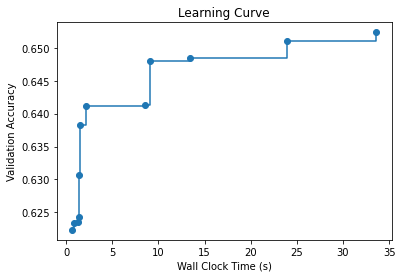

In [84]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Customized Learner

Some experienced automl users may have a preferred model to tune or may already have a reasonably by-hand-tuned model before launching the automl experiment. They need to select optimal configurations for the customized model mixed with standard built-in learners. 

FLAML can easily incorporate customized/new learners (preferably with sklearn API) provided by users in a real-time manner, as demonstrated below.

### Example of Regularized Greedy Forest

[Regularized Greedy Forest](https://arxiv.org/abs/1109.0887) (RGF) is a machine learning method currently not included in FLAML. The RGF has many tuning parameters, the most critical of which are: `[max_leaf, n_iter, n_tree_search, opt_interval, min_samples_leaf]`. To run a customized/new learner, the user needs to provide the following information:
* an implementation of the customized/new learner
* a list of hyperparameter names and types
* rough ranges of hyperparameters (i.e., upper/lower bounds)
* choose initial value corresponding to low cost for cost-related hyperparameters (e.g., initial value for max_leaf and n_iter should be small)

In this example, the above information for RGF is wrapped in a python class called *MyRegularizedGreedyForest* that exposes the hyperparameters.

In [85]:
''' SKLearnEstimator is the super class for a sklearn learner '''
from flaml.model import SKLearnEstimator
from flaml import tune
from rgf.sklearn import RGFClassifier, RGFRegressor


class MyRegularizedGreedyForest(SKLearnEstimator):


    def __init__(self, task='binary:logistic', n_jobs=1, **params):
        '''Constructor
        
        Args:
            task: A string of the task type, one of
                'binary:logistic', 'multi:softmax', 'regression'
            n_jobs: An integer of the number of parallel threads
            params: A dictionary of the hyperparameter names and values
        '''

        super().__init__(task, **params)

        '''task=regression for RGFRegressor; 
        binary:logistic and multiclass:softmax for RGFClassifier'''
        if 'regression' in task:
            self.estimator_class = RGFRegressor
        else:
            self.estimator_class = RGFClassifier

        # convert to int for integer hyperparameters
        self.params = {
            "n_jobs": n_jobs,
            'max_leaf': int(params['max_leaf']),
            'n_iter': int(params['n_iter']),
            'n_tree_search': int(params['n_tree_search']),
            'opt_interval': int(params['opt_interval']),
            'learning_rate': params['learning_rate'],
            'min_samples_leaf': int(params['min_samples_leaf'])
        }    

    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space

        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain and init_value (optional), cat_hp_cost (optional) 
                e.g., 
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}
        '''
        space = {        
            'max_leaf': {'domain': tune.qloguniform(lower=4, upper=data_size, q=1), 'init_value': 4, 'low_cost_init_value': 4},
            'n_iter': {'domain': tune.qloguniform(lower=1, upper=data_size, q=1), 'init_value': 1, 'low_cost_init_value': 1},
            'n_tree_search': {'domain': tune.qloguniform(lower=1, upper=32768, q=1), 'init_value': 1, 'low_cost_init_value': 1},
            'opt_interval': {'domain': tune.qloguniform(lower=1, upper=10000, q=1), 'init_value': 100},
            'learning_rate': {'domain': tune.loguniform(lower=0.01, upper=20.0)},
            'min_samples_leaf': {'domain': tune.qloguniform(lower=1, upper=20, q=1), 'init_value': 20},
        }
        return space

    @classmethod
    def size(cls, config):
        '''[optional method] memory size of the estimator in bytes
        
        Args:
            config - the dict of the hyperparameter config

        Returns:
            A float of the memory size required by the estimator to train the
            given config
        '''
        max_leaves = int(round(config['max_leaf']))
        n_estimators = int(round(config['n_iter']))
        return (max_leaves * 3 + (max_leaves - 1) * 4 + 1.0) * n_estimators * 8

    @classmethod
    def cost_relative2lgbm(cls):
        '''[optional method] relative cost compared to lightgbm
        '''
        return 1.0


### Add Customized Learner and Run FLAML AutoML

After adding RGF into the list of learners, we run automl by tuning hyperpameters of RGF as well as the default learners. 

In [95]:
automl = AutoML()
automl.add_learner(learner_name='RGF', learner_class=MyRegularizedGreedyForest)

In [96]:
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['RGF', 'lgbm', 'rf', 'xgboost'],  # list of ML learners
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment_custom.log',  # flaml log file 
    "log_training_metric": True,  # whether to log training metric
}

'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 07-05 21:51:54] {908} INFO - Evaluation method: holdout
[flaml.automl: 07-05 21:51:54] {607} INFO - Using StratifiedKFold
[flaml.automl: 07-05 21:51:54] {929} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 07-05 21:51:54] {948} INFO - List of ML learners in AutoML Run: ['RGF', 'lgbm', 'rf', 'xgboost']
[flaml.automl: 07-05 21:51:54] {1006} INFO - iteration 0, current learner RGF
[flaml.automl: 07-05 21:51:55] {1152} INFO -  at 1.0s,	best RGF's error=0.3787,	best RGF's error=0.3787
[flaml.automl: 07-05 21:51:55] {1006} INFO - iteration 1, current learner RGF
[flaml.automl: 07-05 21:51:56] {1152} INFO -  at 1.7s,	best RGF's error=0.3787,	best RGF's error=0.3787
[flaml.automl: 07-05 21:51:56] {1006} INFO - iteration 2, current learner lgbm
[flaml.automl: 07-05 21:51:56] {1152} INFO -  at 1.8s,	best lgbm's error=0.3777,	best lgbm's error=0.3777
[flaml.automl: 07-05 21:51:56] {1006} INFO - iteration 3, current learner lgbm
[flaml.automl: 07-05 21:51:56] {1152} INFO 

## 4. Comparison with alternatives

### FLAML's accuracy

In [97]:
print('flaml accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

flaml accuracy = 0.6676060098186078


### Default LightGBM

In [98]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [99]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [100]:
y_pred = lgbm.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default lgbm accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default lgbm accuracy = 0.6602346380315323


### Default XGBoost

In [101]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [102]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
y_pred = xgb.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default xgboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default xgboost accuracy = 0.6676060098186078
